# Set up 

In [ ]:
SEED = 1
import random

import tellurium as te
import pandas as pd
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np
np.random.seed(SEED)

import cobra
import os

from scipy import stats
import scipy as sp
import math

import gzip
import cloudpickle

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
os.chdir('../../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyA/all_data/')

# Perturbing enzymes

In [3]:
Teusink_ant ='../../../models/Antimony/topologyA-noReg.ant' 
r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.5710734600032811e-15

In [4]:
pt_levels = [0.5, 1.5]
pt_labels = ['0.5x', '1.5x']

In [5]:
data_file05 = '../../../data/interim/generated_data/topologyA-noReg/topologyA-noReg_0.5.csv'
data_file15 = '../../../data/interim/generated_data/topologyA-noReg/topologyA-noReg_1.5.csv'


In [6]:
BMCA_obj05 = antemll.antemll(Teusink_ant, data_file05, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj15 = antemll.antemll(Teusink_ant, data_file15, '../../../models/sbml/topologyA_cobra.xml')

No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


In [ ]:
def run_prior_predictive(BMCA_obj):

    ll = emll.LinLogLeastNorm(BMCA_obj.N, BMCA_obj.Ex.to_numpy(), BMCA_obj.Ey.to_numpy(), BMCA_obj.v_star, driver='gelsy')
    
    with pm.Model() as pymc_model:
        # Initialize elasticities
        # Ex and Ey have to be shape (rxns, mets)
        Ex_t = pm.Deterministic('Ex', emll.util.initialize_elasticity(BMCA_obj.Ex.to_numpy().T, 'Ex', b=0.05, sd=1, alpha=5))
        Ey_t = pm.Deterministic('Ey', emll.util.initialize_elasticity(BMCA_obj.Ey.to_numpy().T, 'Ey', b=0.05, sd=1, alpha=5))

        trace_prior = pm.sample_prior_predictive(random_seed=SEED)

    return trace_prior

In [8]:
prior05 = run_prior_predictive(BMCA_obj05)
prior15 = run_prior_predictive(BMCA_obj15)


Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]


# Running ADVI

In [ ]:
def run_ADVI(BMCA_obj):
    np.random.seed(SEED)
    random.seed(SEED)


    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 45000
    
    with pymc_model:
        advi = pm.ADVI(random_seed=SEED)
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=       N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    with pymc_model:
        trace = approx.sample(draws=1000, random_seed=SEED)
        ppc_vi = pm.sample_posterior_predictive(trace, random_seed=random_range)

    return trace, ppc_vi

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,002.7
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 957.46
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


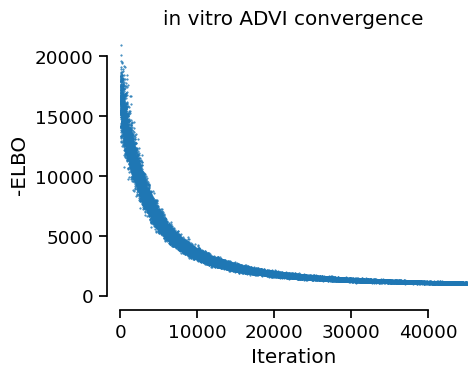

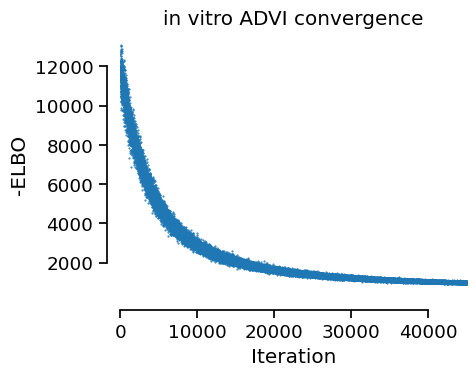

In [10]:
trace05, ppc05 = run_ADVI(BMCA_obj05)
trace15, ppc15 = run_ADVI(BMCA_obj15) 

### saving trace data

In [11]:
with gzip.open("topologyA-noReg_allData_traces-2.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "ppc05":ppc05,
                "ppc15":ppc15,
                "trace05":trace05,
                "trace15":trace15,
                },
                f,
            )

# Analysis

In [9]:
picklefolder = ''
with gzip.open(picklefolder + 'topologyA-noReg_allData_traces-2.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

In [10]:
trace05 = traces['trace05']
trace15 = traces['trace15']

ppc05 = traces['ppc05']
ppc15 = traces['ppc15']

In [11]:
v_ppc05 = az.summary(ppc05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc15 = az.summary(ppc15['posterior_predictive']['v_hat_obs'])['mean']

x_ppc05 = az.summary(ppc05['posterior_predictive']['chi_obs'])['mean']
x_ppc15 = az.summary(ppc15['posterior_predictive']['chi_obs'])['mean']

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


#### Known flux and metabolite concentrations check

Text(0.5, 0.98, 'BMCA on Topology A, 0.5x pt, allData')

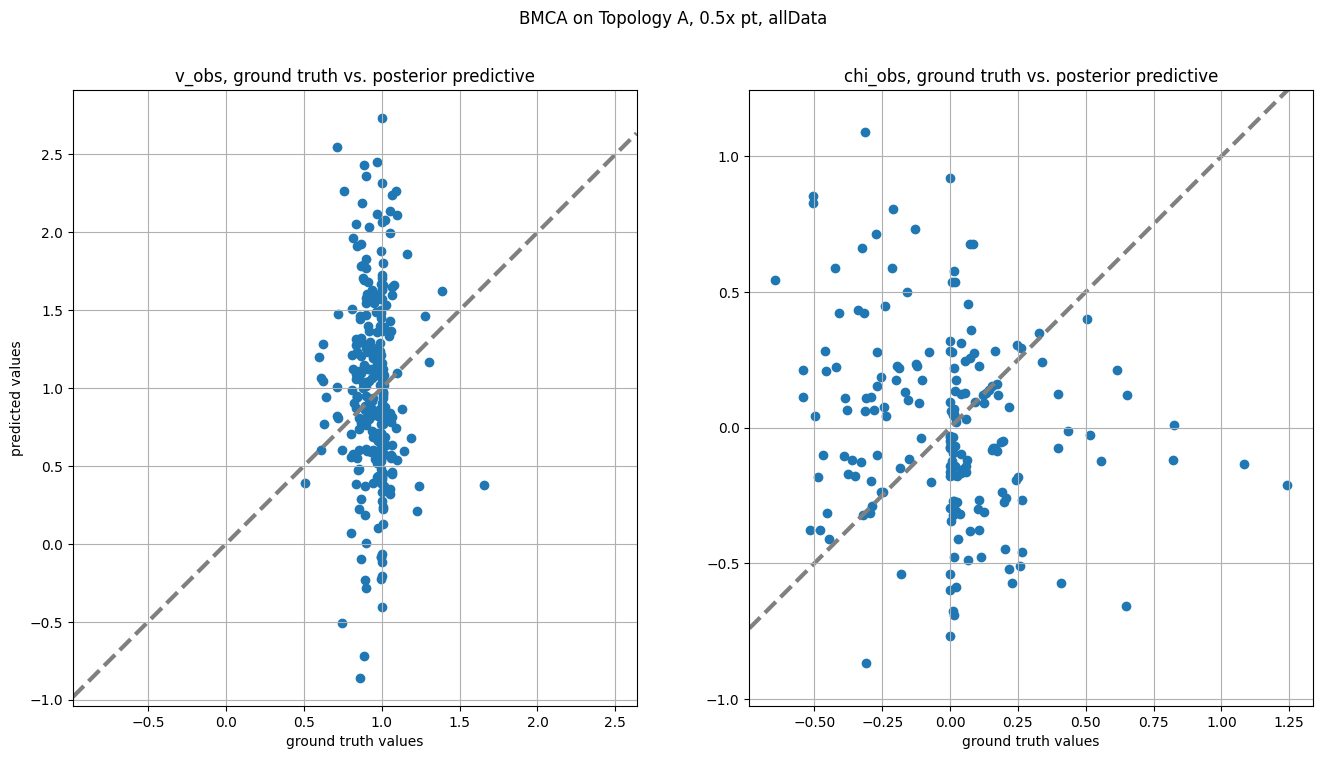

In [12]:
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

ax1.set_aspect('equal', 'datalim')
ax1.scatter(BMCA_obj05.vn.values, v_ppc05.values.reshape((16,-1)))
ax1.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax1.set_title('v_obs, ground truth vs. posterior predictive')
ax1.set_xlabel('ground truth values')
ax1.set_ylabel('predicted values')
ax1.grid()

ax2.set_aspect('equal', 'datalim')
ax2.scatter(BMCA_obj05.xn.values, x_ppc05.values.reshape((17,-1)))
ax2.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax2.set_title('chi_obs, ground truth vs. posterior predictive')
ax2.set_xlabel('ground truth values')
ax2.grid()

f.suptitle('BMCA on Topology A, 0.5x pt, allData')

Text(0.5, 0.98, 'BMCA on Topology A, 1.5x pt, allData')

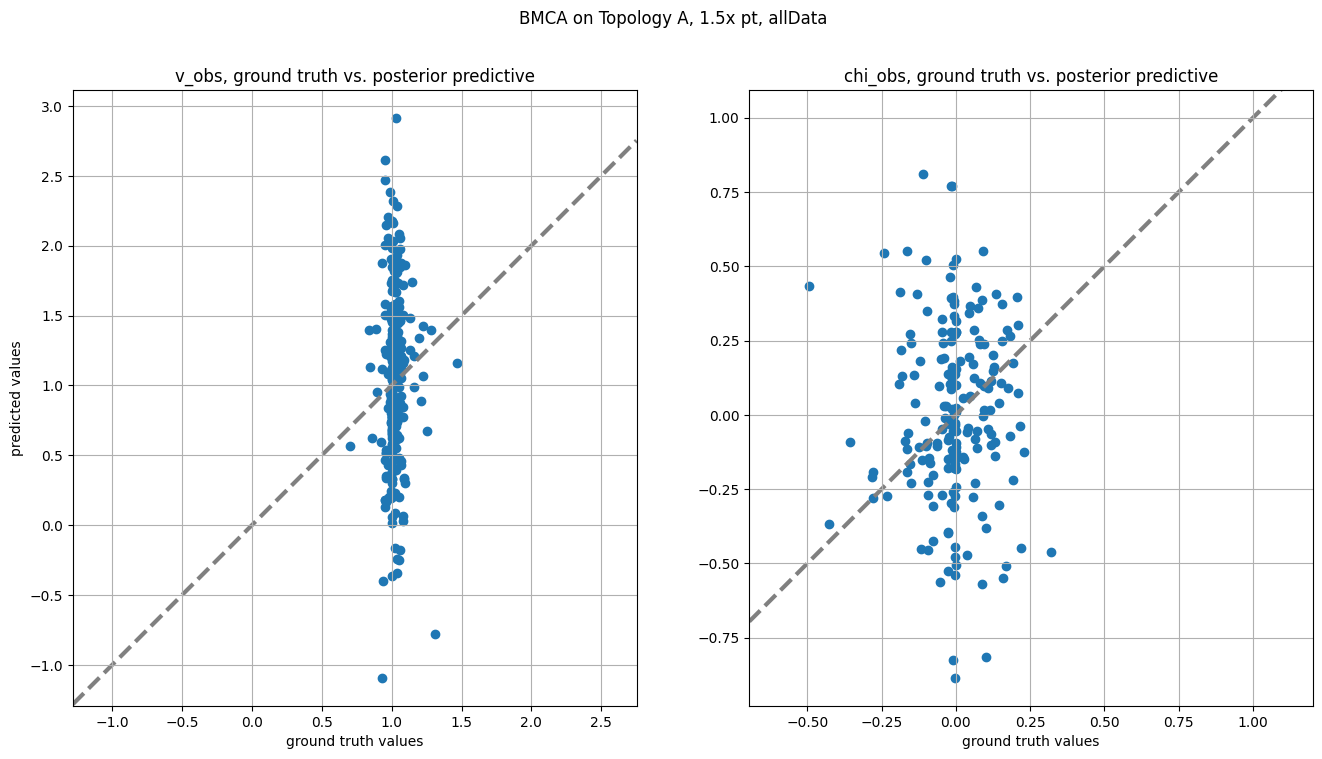

In [13]:
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

ax1.set_aspect('equal', 'datalim')
ax1.scatter(BMCA_obj15.vn.values, v_ppc15.values.reshape((16,-1)))
ax1.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax1.set_title('v_obs, ground truth vs. posterior predictive')
ax1.set_xlabel('ground truth values')
ax1.set_ylabel('predicted values')
ax1.grid()

ax2.set_aspect('equal', 'datalim')
ax2.scatter(BMCA_obj15.xn.values, x_ppc15.values.reshape((17,-1)))
ax2.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax2.set_title('chi_obs, ground truth vs. posterior predictive')
ax2.set_xlabel('ground truth values')
ax2.grid()

f.suptitle('BMCA on Topology A, 1.5x pt, allData')

#### Elasticity check

In [14]:
Ex05_advi = util.get_az_summary(trace05)
Ex15_advi = util.get_az_summary(trace15)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [15]:
prior_Ex05_advi = az.summary(prior05['prior']['Ex'],stat_focus="mean")['mean']
prior_Ex15_advi = az.summary(prior15['prior']['Ex'],stat_focus="mean")['mean']

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


In [16]:
pt_labels= ['0.5x-pr', '1.5x-pr', '0.5x-post', '1.5x-post']

In [17]:
elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten(),
                                prior_Ex05_advi, prior_Ex15_advi, Ex05_advi, Ex15_advi])

elasticities_df = pd.DataFrame(elasticity_values, columns=['gt']+pt_labels,
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
# elasticities_df.to_csv('topologyA_allData_elasticities.csv')

In [18]:
e_slopes = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[0],3) for i in pt_labels]
e_intercepts = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[1],3) for i in pt_labels]
e_r2s = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[2],3) for i in pt_labels]

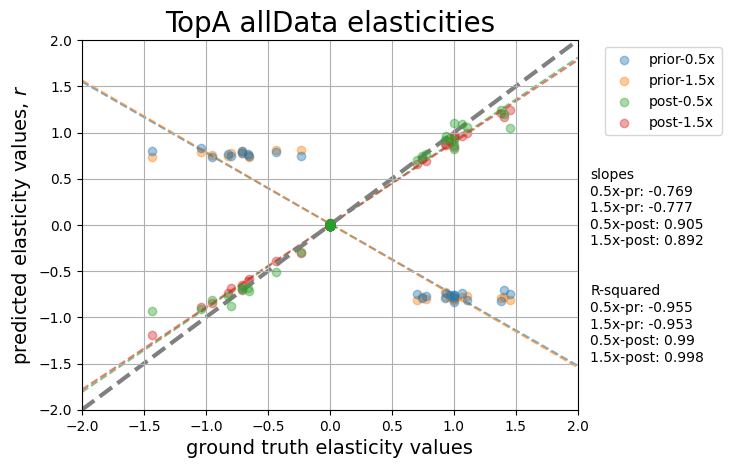

In [19]:
## Elasticities, comparison of prior and post 
plt.ylim(-2,2)
plt.xlim(-2,2)

plt.scatter(elasticities_df['gt'], elasticities_df['0.5x-pr'], alpha=0.4, label='prior-0.5x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['1.5x-pr'], alpha=0.4, label='prior-1.5x')

plt.scatter(elasticities_df['gt'], elasticities_df['0.5x-post'], alpha=0.4, label='post-0.5x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['1.5x-post'], alpha=0.4, label='post-1.5x')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
# plt.title('Parity plot of elasticity values for various \nenzyme perturbation strengths—CRISPRi', size=20)
plt.title('TopA allData elasticities', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 2.1
line_spacing = 0.18
slope_start = 0.5
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(4):
    plt.axline((0, e_intercepts[i]), slope=e_slopes[i], linestyle='--', alpha=0.6, color=colors[i], zorder=0)


In [20]:
# print out MAE for each perturbation strength
MAE = abs(elasticities_df.sub(elasticities_df['gt'], axis=0)).sum()/len(elasticities_df['gt'])
MAE

gt           0.000000
0.5x-pr      0.252129
1.5x-pr      0.253435
0.5x-post    0.017228
1.5x-post    0.017474
dtype: float64

In [21]:
MAE.to_csv('../../../data/results/MAE/topologyA-noReg_allData_MAE-2.csv')

## Calculating FCCs

In [22]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

### Negative predictions

In [23]:
Ex05_prior = util.get_az_summary(prior05['prior']['Ex'])
Ex15_prior = util.get_az_summary(prior15['prior']['Ex'])


arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


In [24]:
priorFCC05 = util.estimate_CCs(BMCA_obj05, Ex05_prior.reshape((16,-1)))
priorFCC15 = util.estimate_CCs(BMCA_obj15, Ex15_prior.reshape((16,-1)))

postFCC05 = util.estimate_CCs(BMCA_obj05, Ex05_advi.reshape((16,-1)))
postFCC15 = util.estimate_CCs(BMCA_obj15, Ex15_advi.reshape((16,-1)))

In [25]:
prior_FCCs = [priorFCC05, priorFCC15]
post_FCCs = [postFCC05, postFCC15]


In [26]:
prd_priorFCCs = pd.concat([util.append_FCC_df(prior_FCCs[i], pt_labels[i], r) for i in range(len(prior_FCCs))])
prd_postFCCs = pd.concat([util.append_FCC_df(post_FCCs[i], pt_labels[i], r) for i in range(len(post_FCCs))])

## Evaluating FCC ranking

In [27]:
gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')

a = gtFCC_rankings.loc['vYAN']

### via Spearman rank coefficients

In [29]:
spearman_coefficients = []
p_values = []
confidence_intervals = []
b_list = []
for FCC in prior_FCCs + post_FCCs:
    b = util.calculate_FCC_med_rankings(FCC, 'vYAN', r)
    b_list.append(b)
    spearman_r, p_value, lower_ci, upper_ci = util.bootstrap_spearman(a.dropna(), b.dropna())
    spearman_coefficients.append(spearman_r)
    p_values.append(p_value)
    confidence_intervals.append((lower_ci, upper_ci))


In [30]:
spearman_df = pd.DataFrame(spearman_coefficients, columns=['r'], index=pt_labels)
spearman_df['p-value'] = p_values
spearman_df['lower'] = [i[0] for i in confidence_intervals]
spearman_df['upper'] = [i[1] for i in confidence_intervals]
spearman_df

,r,p-value,lower,upper
0.5x-pr,0.167857,5.498556e-01,-0.489348,0.744093
1.5x-pr,0.357143,1.912748e-01,-0.195100,0.785984
0.5x-post,0.917857,1.417697e-06,0.724125,0.989011
1.5x-post,0.989286,2.998934e-12,0.930109,1.000000


In [31]:
spearman_df.to_csv('../../../data/results/spearman_coefficients/topologyA-noReg_allData_spr-2.csv')

(0.0, 1.05)

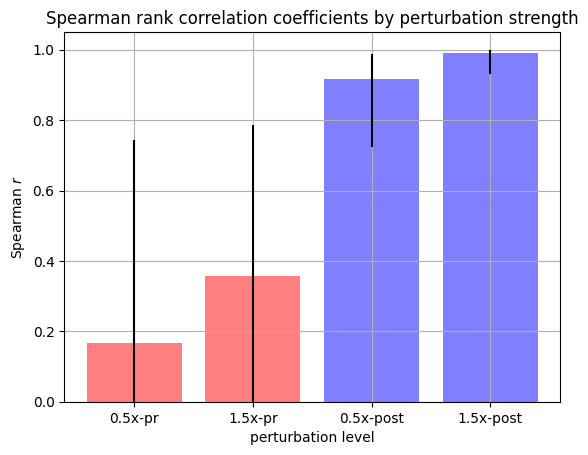

In [32]:
plt.bar(pt_labels, spearman_df['r'], alpha=0.5, color=['r','r','b','b'])
plt.grid()

for i, txt in enumerate(spearman_df['r']):
    plt.vlines(pt_labels[i], spearman_df['lower'][i], spearman_df['upper'][i], color='k')

plt.title("Spearman rank correlation coefficients by perturbation strength")
plt.xlabel('perturbation level')
plt.ylabel('Spearman $\it{r}$')
plt.ylim((0, 1.05))

### evaluating top 10 rankings

In [33]:
b_list = []
for FCC in prior_FCCs + post_FCCs:
    b = util.calculate_FCC_med_rankings(FCC,'vYAN',r)
    b_list.append(b)

In [34]:
ranked_b_list = [b.sort_values().reset_index().set_index('vYAN') for b in b_list]
q = pd.concat(ranked_b_list, axis=1)
q['gt'] = a.sort_values().reset_index().set_index('vYAN')
q.columns = pt_labels + ['gt']
q = q[['gt'] + pt_labels]
q.head(15) ## top 15 table

,gt,0.5x-pr,1.5x-pr,0.5x-post,1.5x-post
vYAN,,,,,
1.0,vWHI,vWHI,vWHI,vWHI,vWHI
2.0,vQUE,vTAN,vROM,vALP,vQUE
3.0,vLIM,vQUE,vSIE,vLIM,vLIM
4.0,vALP,vVIC,vQUE,vQUE,vROM
5.0,vROM,vUNI,vTAN,vNOV,vALP
6.0,vOSC,vSIE,vUNI,vOSC,vOSC
7.0,vNOV,vROM,vVIC,vKIL,vPAP
8.0,vPAP,vOSC,vPAP,vROM,vNOV
9.0,vSIE,vLIM,vLIM,vZUL,vSIE


In [35]:
q.to_csv('../../../data/results/rankings/topologyA-noReg_allData_rankings-2.csv')

In [36]:
rank_df = pd.read_csv('../../../data/results/rankings/topologyA-noReg_allData_rankings-2.csv')

In [37]:
topTen_df = rank_df[rank_df['vYAN'].isin([1,2,3,4,5,6,7,8,9,10])]

gt_t10_set = set(list(topTen_df['gt']))

t10_sets = []
for pt in pt_labels: 
    t10_sets.append(set(list(topTen_df[pt])))

t10_scores=[]
for i in t10_sets: 
    t10_scores.append(len(set.intersection(gt_t10_set, i)))

t10_results = pd.DataFrame((np.array(t10_scores)).reshape((len(pt_labels),-1)).T, 
             columns=pt_labels)
t10_results ## number of correct predictions of top 10 FCC values 

,0.5x-pr,1.5x-pr,0.5x-post,1.5x-post
0,7,7,9,10


In [49]:
# difference
dif_list = []
for i in t10_sets: 
    dif_list.append(i.difference(gt_t10_set))

for i in dif_list: 
    print(rank_df['gt'].loc[lambda x: x.isin(i)].index)

Int64Index([11, 12, 13], dtype='int64')
Int64Index([11, 12, 13], dtype='int64')
Int64Index([10], dtype='int64')
Int64Index([], dtype='int64')
